
Модель 1: Регуляризованная регрессия (Ridge + Lasso)

Лучшие параметры для Ridge: {'alpha': 100, 'max_iter': 1000}


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.161e+01, tolerance: 1.689e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.023e+01, tolerance: 1.622e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.775e+01, tolerance: 

Лучшие параметры для Lasso: {'alpha': 0.01, 'max_iter': 1000}

Выбрана Ridge регрессия как лучшая модель

Модель 2: Ансамблевые методы (Random Forest + Gradient Boosting)

Лучшие параметры для Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Лучшие параметры для Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Выбрана Gradient Boosting как лучшая модель

Сравнение производительности моделей

Регуляризованная регрессия:
RMSE: 1.1301
MAE: 0.8554
R2: 0.4384


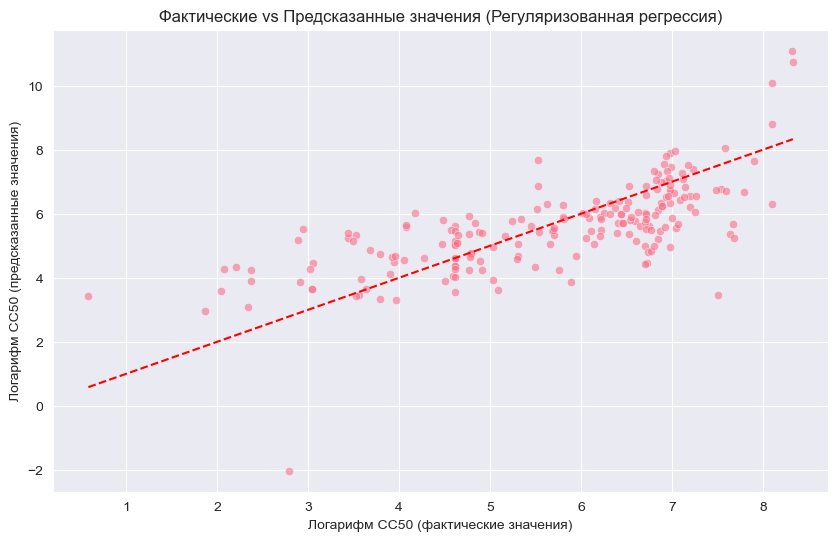


Ансамблевая модель:
RMSE: 0.3179
MAE: 0.1681
R2: 0.9556


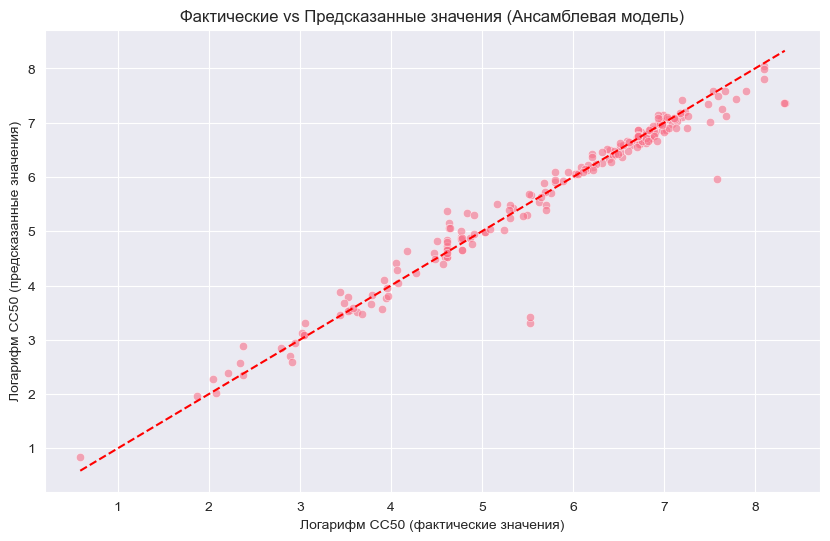


Лучшая модель: Ансамблевая модель (R2 = 0.956)


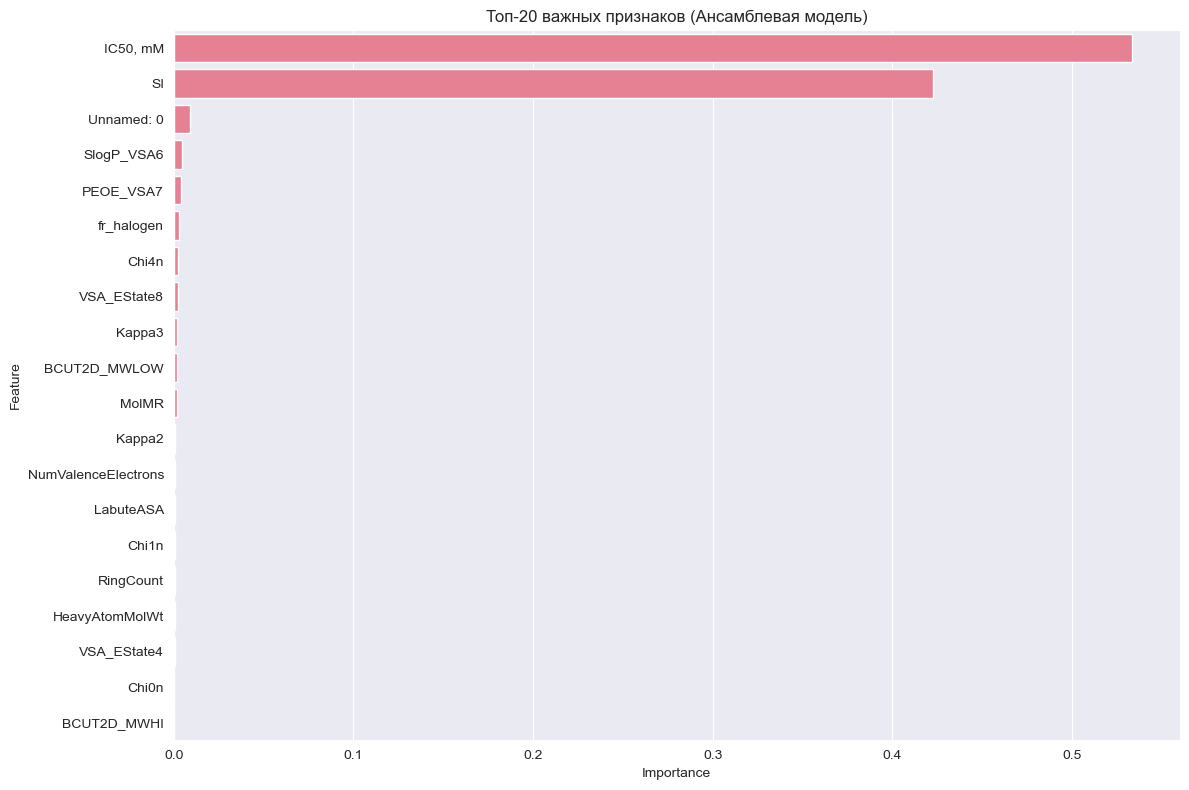

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
sns.set_palette("husl")

# 1. Загрузка и подготовка данных
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    
    # Логарифмирование целевой переменной (из-за skewness)
    if 'CC50, mM' in df.columns:
        df['CC50_log'] = np.log1p(df['CC50, mM'])
    else:
        raise KeyError("Column 'CC50, mM' not found in the dataset")
    
    return df

# 2. Разделение данных и масштабирование
def prepare_for_modeling(df, target_col='CC50_log'):
    X = df.drop(['CC50, mM', target_col], axis=1, errors='ignore')
    y = df[target_col]
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Масштабирование числовых признаков
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train, X_test, y_train, y_test, scaler

# 3. Функции для оценки моделей
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    }
    return metrics

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f'Фактические vs Предсказанные значения ({model_name})')
    plt.xlabel('Логарифм CC50 (фактические значения)')
    plt.ylabel('Логарифм CC50 (предсказанные значения)')
    plt.grid(True)
    plt.show()

# 4. Модель 1: Регуляризованная регрессия с подбором гиперпараметров
def build_regularized_model(X_train, y_train):
    print("\n" + "="*50)
    print("Модель 1: Регуляризованная регрессия (Ridge + Lasso)")
    print("="*50)
    
    # Параметры для GridSearch
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 5000]
    }
    
    # Ridge Regression
    ridge = Ridge(random_state=42)
    ridge_grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    ridge_grid.fit(X_train, y_train)
    print("\nЛучшие параметры для Ridge:", ridge_grid.best_params_)
    
    # Lasso Regression
    lasso = Lasso(random_state=42)
    lasso_grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_grid.fit(X_train, y_train)
    print("Лучшие параметры для Lasso:", lasso_grid.best_params_)
    
    # Выбираем лучшую модель
    if ridge_grid.best_score_ > lasso_grid.best_score_:
        best_model = ridge_grid.best_estimator_
        print("\nВыбрана Ridge регрессия как лучшая модель")
    else:
        best_model = lasso_grid.best_estimator_
        print("\nВыбрана Lasso регрессия как лучшая модель")
    
    return best_model

# 5. Модель 2: Ансамблевые методы с подбором гиперпараметров
def build_ensemble_model(X_train, y_train):
    print("\n" + "="*50)
    print("Модель 2: Ансамблевые методы (Random Forest + Gradient Boosting)")
    print("="*50)
    
    # Random Forest
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=1)
    rf_grid.fit(X_train, y_train)
    print("\nЛучшие параметры для Random Forest:", rf_grid.best_params_)
    
    # Gradient Boosting
    gb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    gb = GradientBoostingRegressor(random_state=42)
    gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    gb_grid.fit(X_train, y_train)
    print("Лучшие параметры для Gradient Boosting:", gb_grid.best_params_)
    
    # Выбираем лучшую модель
    if rf_grid.best_score_ > gb_grid.best_score_:
        best_model = rf_grid.best_estimator_
        print("\nВыбрана Random Forest как лучшая модель")
    else:
        best_model = gb_grid.best_estimator_
        print("\nВыбрана Gradient Boosting как лучшая модель")
    
    return best_model

# 6. Сравнение моделей
def compare_models(models, X_test, y_test):
    results = {}
    print("\n" + "="*50)
    print("Сравнение производительности моделей")
    print("="*50)
    
    for name, model in models.items():
        metrics = evaluate_model(model, X_test, y_test)
        results[name] = metrics
        print(f"\n{name}:")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"R2: {metrics['R2']:.4f}")
        
        # Визуализация предсказаний
        preds = model.predict(X_test)
        plot_predictions(y_test, preds, name)
    
    return pd.DataFrame(results).T

# 7. Анализ важности признаков
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print("Модель не поддерживает анализ важности признаков")
        return
    
    # Создаем DataFrame с важностью признаков
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'Топ-20 важных признаков ({model_name})')
    plt.tight_layout()
    plt.show()

# Главная функция
def main():
    # Загрузка данных
    filepath = 'cleaned_data.csv'
    try:
        df = load_and_prepare_data(filepath)
    except Exception as e:
        print(f"Ошибка при загрузке данных: {str(e)}")
        return
    
    # Подготовка данных для моделирования
    X_train, X_test, y_train, y_test, scaler = prepare_for_modeling(df)
    
    # Построение моделей
    model1 = build_regularized_model(X_train, y_train)
    model2 = build_ensemble_model(X_train, y_train)
    
    # Сравнение моделей
    models = {
        'Регуляризованная регрессия': model1,
        'Ансамблевая модель': model2
    }
    results_df = compare_models(models, X_test, y_test)
    
    # Анализ важности признаков для лучшей модели
    if not results_df.empty:
        best_model_name = results_df['R2'].idxmax()
        best_model = models[best_model_name]
        print(f"\nЛучшая модель: {best_model_name} (R2 = {results_df.loc[best_model_name, 'R2']:.3f})")
        
        plot_feature_importance(best_model, X_train.columns, best_model_name)

if __name__ == "__main__":
    main()
